# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture.

<img src="assets/cnnarchitecture.jpg" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but replace the final fully connected layers with our own classifier. This way we can use VGGNet as a feature extractor for our images then easily train a simple classifier on top of that. What we'll do is take the first fully connected layer with 4096 units, including thresholding with ReLUs. We can use those values as a code for each image, then build a classifier on top of those codes.

You can read more about transfer learning from [the CS231n course notes](http://cs231n.github.io/transfer-learning/#tf).

## Pretrained VGGNet

We'll be using a pretrained network from https://github.com/machrisaa/tensorflow-vgg. Make sure to clone this repository to the directory you're working from. You'll also want to rename it so it has an underscore instead of a dash.

```
git clone https://github.com/machrisaa/tensorflow-vgg.git tensorflow_vgg
```

This is a really nice implementation of VGGNet, quite easy to work with. The network has already been trained and the parameters are available from this link. _You'll need to clone the repo into the folder containing this notebook._ Then download the parameter file using the next cell.

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

vgg_dir = 'tensorflow_vgg/'
# Make sure vgg exists
if not isdir(vgg_dir):
    raise Exception("VGG directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(vgg_dir + "vgg16.npy"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='VGG16 Parameters') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/content.udacity-data.com/nd101/vgg16.npy',
            vgg_dir + 'vgg16.npy',
            pbar.hook)
else:
    print("Parameter file already exists!")

Parameter file already exists!


## Flower power

Here we'll be using VGGNet to classify images of flowers. To get the flower dataset, run the cell below. This dataset comes from the [TensorFlow inception tutorial](https://www.tensorflow.org/tutorials/image_retraining).

In [2]:
import tarfile

dataset_folder_path = 'flower_photos'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('flower_photos.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Flowers Dataset') as pbar:
        urlretrieve(
            'http://download.tensorflow.org/example_images/flower_photos.tgz',
            'flower_photos.tar.gz',
            pbar.hook)

if not isdir(dataset_folder_path):
    with tarfile.open('flower_photos.tar.gz') as tar:
        tar.extractall()
        tar.close()

## ConvNet Codes

Below, we'll run through all the images in our dataset and get codes for each of them. That is, we'll run the images through the VGGNet convolutional layers and record the values of the first fully connected layer. We can then write these to a file for later when we build our own classifier.

Here we're using the `vgg16` module from `tensorflow_vgg`. The network takes images of size $224 \times 224 \times 3$ as input. Then it has 5 sets of convolutional layers. The network implemented here has this structure (copied from [the source code](https://github.com/machrisaa/tensorflow-vgg/blob/master/vgg16.py)):

```
self.conv1_1 = self.conv_layer(bgr, "conv1_1")
self.conv1_2 = self.conv_layer(self.conv1_1, "conv1_2")
self.pool1 = self.max_pool(self.conv1_2, 'pool1')

self.conv2_1 = self.conv_layer(self.pool1, "conv2_1")
self.conv2_2 = self.conv_layer(self.conv2_1, "conv2_2")
self.pool2 = self.max_pool(self.conv2_2, 'pool2')

self.conv3_1 = self.conv_layer(self.pool2, "conv3_1")
self.conv3_2 = self.conv_layer(self.conv3_1, "conv3_2")
self.conv3_3 = self.conv_layer(self.conv3_2, "conv3_3")
self.pool3 = self.max_pool(self.conv3_3, 'pool3')

self.conv4_1 = self.conv_layer(self.pool3, "conv4_1")
self.conv4_2 = self.conv_layer(self.conv4_1, "conv4_2")
self.conv4_3 = self.conv_layer(self.conv4_2, "conv4_3")
self.pool4 = self.max_pool(self.conv4_3, 'pool4')

self.conv5_1 = self.conv_layer(self.pool4, "conv5_1")
self.conv5_2 = self.conv_layer(self.conv5_1, "conv5_2")
self.conv5_3 = self.conv_layer(self.conv5_2, "conv5_3")
self.pool5 = self.max_pool(self.conv5_3, 'pool5')

self.fc6 = self.fc_layer(self.pool5, "fc6")
self.relu6 = tf.nn.relu(self.fc6)
```

So what we want are the values of the first fully connected layer, after being ReLUd (`self.relu6`).

In [3]:
import os

import numpy as np
import tensorflow as tf

from tensorflow_vgg import vgg16
from tensorflow_vgg import utils

In [4]:
data_dir = 'flower_photos/'
contents = os.listdir(data_dir)
classes = [each for each in contents if os.path.isdir(data_dir + each)]

Below I'm running images through the VGG network in batches.

In [5]:
# Set the batch size higher if you can fit in in your GPU memory
batch_size = 100
codes_list = []
labels = []
batch = []

codes = None
vgg = vgg16.Vgg16()
input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
with tf.name_scope("content_vgg"):
    vgg.build(input_)
        

with tf.Session() as sess:
    for each in classes:
        print("Starting {} images".format(each))
        class_path = data_dir + each
        files = os.listdir(class_path)
        for ii, file in enumerate(files, 1):
            # Add images to the current batch
            # utils.load_image crops the input images for us, from the center
            img = utils.load_image(os.path.join(class_path, file))
            batch.append(img.reshape((1, 224, 224, 3)))
            labels.append(each)
            
            # Running the batch through the network to get the codes
            if ii % batch_size == 0 or ii == len(files):
                
                # Image batch to pass to VGG network
                images = np.concatenate(batch)
                
                feed_dict = {input_: images}
                codes_batch =  sess.run(vgg.relu6, feed_dict=feed_dict)
                
                # Here I'm building an array of the codes
                if codes is None:
                    codes = codes_batch
                else:
                    codes = np.concatenate((codes, codes_batch))
                
                # Reset to start building the next batch
                batch = []
                print('{} images processed'.format(ii))

/home/adrsta/Github/deep-learning/transfer-learning/tensorflow_vgg/vgg16.npy
npy file loaded
build model started
build model finished: 0s
Starting sunflowers images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
699 images processed
Starting dandelion images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
800 images processed
898 images processed
Starting tulips images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
700 images processed
799 images processed
Starting roses images
100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed
641 images processed
Starting daisy images
100 images processed
200 images processed
300 images processed
400 images processed
500 ima

In [6]:
# write codes to file
with open('codes', 'w') as f:
    codes.tofile(f)
    
# write labels to file
import csv
with open('labels', 'w') as f:
    writer = csv.writer(f, delimiter='\n')
    writer.writerow(labels)

## Building the Classifier

Now that we have codes for all the images, we can build a simple classifier on top of them. The codes behave just like normal input into a simple neural network. Below I'm going to have you do most of the work.

In [7]:
# read codes and labels from file
import csv

with open('labels') as f:
    reader = csv.reader(f, delimiter='\n')
    labels = np.array([each for each in reader if len(each) > 0]).squeeze()
with open('codes') as f:
    codes = np.fromfile(f, dtype=np.float32)
    codes = codes.reshape((len(labels), -1))

### Data prep

As usual, now we need to one-hot encode our labels and create validation/test sets. First up, creating our labels!

From scikit-learn, use [LabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html) to create one-hot encoded vectors from the labels. 

In [8]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit(labels)
labels_vecs = lb.transform(labels)
labels_vecs

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ..., 
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0]])

Now you'll want to create your training, validation, and test sets. An important thing to note here is that our labels and data aren't randomized yet. We'll want to shuffle our data so the validation and test sets contain data from all classes. Otherwise, you could end up with testing sets that are all one class. Typically, you'll also want to make sure that each smaller set has the same the distribution of classes as it is for the whole data set. The easiest way to accomplish both these goals is to use [StratifiedShuffleSplit](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html) from scikit-learn.

You can create the splitter like so:
```
ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
```
Then split the data with 
```
splitter = ss.split(x, y)
```

`ss.split` returns a generator of indices. You can pass the indices into the arrays to get the split sets. The fact that it's a generator means you either need to iterate over it, or use `next(splitter)` to get the indices.

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(codes, labels_vecs):
    train_x, rest_x = codes[train_index], codes[test_index]
    train_y, rest_y = labels_vecs[train_index], labels_vecs[test_index]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(rest_x, rest_y):
    val_x, test_x = rest_x[train_index], rest_x[test_index]
    val_y, test_y = rest_y[train_index], rest_y[test_index]

In [10]:
print("Train shapes (x, y):", train_x.shape, train_y.shape)
print("Validation shapes (x, y):", val_x.shape, val_y.shape)
print("Test shapes (x, y):", test_x.shape, test_y.shape)

Train shapes (x, y): (2936, 4096) (2936, 5)
Validation shapes (x, y): (367, 4096) (367, 5)
Test shapes (x, y): (367, 4096) (367, 5)


### Classifier layers

Once you have the convolutional codes, you just need to build a classfier from some fully connected layers. You use the codes as the inputs and the image labels as targets. Otherwise the classifier is a typical neural network.

> **Exercise:** With the codes and labels loaded, build the classifier. Consider the codes as your inputs, each of them are 4096D vectors. You'll want to use a hidden layer and an output layer as your classifier. Remember that the output layer needs to have one unit for each class and a softmax activation function. Use the cross entropy to calculate the cost.

In [11]:
from tensorflow import layers

In [12]:
inputs_ = tf.placeholder(tf.float32, shape=[None, codes.shape[1]])
labels_ = tf.placeholder(tf.int64, shape=[None, labels_vecs.shape[1]])

fc = tf.layers.dense(inputs_, 2000, activation=tf.nn.relu)
logits = tf.layers.dense(fc, labels_vecs.shape[1], activation=None)

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=labels_,
                                                             logits=logits))

optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)

# Operations for validation/test accuracy
predicted = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(predicted, 1), tf.argmax(labels_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

### Batches!

Here is just a simple way to do batches. I've written it so that it includes all the data. Sometimes you'll throw out some data at the end to make sure you have full batches. Here I just extend the last batch to include the remaining data.

In [13]:
def get_batches(x, y, n_batches=10):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else:
            X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

### Training

Here, we'll train the network.


In [14]:
epochs = 10
batches = 100
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        b = 0
        for x, y in get_batches(train_x, train_y, batches):
            feed = {inputs_: x,
                    labels_: y}
            batch_cost, _ = sess.run([cost, optimizer], feed_dict=feed)
            print("Epoch: {}/{} ".format(e+1, epochs),
                  "Batch: {}/{} ".format(b+1, batches),
                  "Training loss: {:.4f}".format(batch_cost))
            b += 1      
    saver.save(sess, "checkpoints/flowers.ckpt")

Epoch: 1/10  Batch: 1/100  Training loss: 180.7637
Epoch: 1/10  Batch: 2/100  Training loss: 157.0287
Epoch: 1/10  Batch: 3/100  Training loss: 96.1030
Epoch: 1/10  Batch: 4/100  Training loss: 103.2299
Epoch: 1/10  Batch: 5/100  Training loss: 34.5543
Epoch: 1/10  Batch: 6/100  Training loss: 59.7636
Epoch: 1/10  Batch: 7/100  Training loss: 32.1753
Epoch: 1/10  Batch: 8/100  Training loss: 40.5630
Epoch: 1/10  Batch: 9/100  Training loss: 26.0157
Epoch: 1/10  Batch: 10/100  Training loss: 48.7818
Epoch: 1/10  Batch: 11/100  Training loss: 73.2099
Epoch: 1/10  Batch: 12/100  Training loss: 43.3964
Epoch: 1/10  Batch: 13/100  Training loss: 24.9383
Epoch: 1/10  Batch: 14/100  Training loss: 28.2829
Epoch: 1/10  Batch: 15/100  Training loss: 20.6874
Epoch: 1/10  Batch: 16/100  Training loss: 26.8465
Epoch: 1/10  Batch: 17/100  Training loss: 56.6929
Epoch: 1/10  Batch: 18/100  Training loss: 27.2449
Epoch: 1/10  Batch: 19/100  Training loss: 48.2927
Epoch: 1/10  Batch: 20/100  Training 

Epoch: 3/10  Batch: 13/100  Training loss: 2.0531
Epoch: 3/10  Batch: 14/100  Training loss: 1.7818
Epoch: 3/10  Batch: 15/100  Training loss: 1.4329
Epoch: 3/10  Batch: 16/100  Training loss: 0.6691
Epoch: 3/10  Batch: 17/100  Training loss: 4.7530
Epoch: 3/10  Batch: 18/100  Training loss: 0.1015
Epoch: 3/10  Batch: 19/100  Training loss: 0.9314
Epoch: 3/10  Batch: 20/100  Training loss: 0.9602
Epoch: 3/10  Batch: 21/100  Training loss: 3.8207
Epoch: 3/10  Batch: 22/100  Training loss: 4.8147
Epoch: 3/10  Batch: 23/100  Training loss: 0.0952
Epoch: 3/10  Batch: 24/100  Training loss: 0.2240
Epoch: 3/10  Batch: 25/100  Training loss: 0.7781
Epoch: 3/10  Batch: 26/100  Training loss: 0.0147
Epoch: 3/10  Batch: 27/100  Training loss: 0.3487
Epoch: 3/10  Batch: 28/100  Training loss: 10.3032
Epoch: 3/10  Batch: 29/100  Training loss: 0.1085
Epoch: 3/10  Batch: 30/100  Training loss: 0.5953
Epoch: 3/10  Batch: 31/100  Training loss: 2.6776
Epoch: 3/10  Batch: 32/100  Training loss: 1.0370

Epoch: 4/10  Batch: 96/100  Training loss: 0.0249
Epoch: 4/10  Batch: 97/100  Training loss: 0.0443
Epoch: 4/10  Batch: 98/100  Training loss: 0.0447
Epoch: 4/10  Batch: 99/100  Training loss: 2.1157
Epoch: 4/10  Batch: 100/100  Training loss: 0.0883
Epoch: 5/10  Batch: 1/100  Training loss: 0.2744
Epoch: 5/10  Batch: 2/100  Training loss: 0.0285
Epoch: 5/10  Batch: 3/100  Training loss: 0.0558
Epoch: 5/10  Batch: 4/100  Training loss: 0.0768
Epoch: 5/10  Batch: 5/100  Training loss: 0.1883
Epoch: 5/10  Batch: 6/100  Training loss: 0.3246
Epoch: 5/10  Batch: 7/100  Training loss: 0.5382
Epoch: 5/10  Batch: 8/100  Training loss: 0.0749
Epoch: 5/10  Batch: 9/100  Training loss: 0.0058
Epoch: 5/10  Batch: 10/100  Training loss: 0.0187
Epoch: 5/10  Batch: 11/100  Training loss: 0.2647
Epoch: 5/10  Batch: 12/100  Training loss: 2.5571
Epoch: 5/10  Batch: 13/100  Training loss: 0.0407
Epoch: 5/10  Batch: 14/100  Training loss: 0.0129
Epoch: 5/10  Batch: 15/100  Training loss: 0.0113
Epoch: 5

Epoch: 6/10  Batch: 72/100  Training loss: 0.0203
Epoch: 6/10  Batch: 73/100  Training loss: 0.0049
Epoch: 6/10  Batch: 74/100  Training loss: 0.0144
Epoch: 6/10  Batch: 75/100  Training loss: 0.1056
Epoch: 6/10  Batch: 76/100  Training loss: 0.0020
Epoch: 6/10  Batch: 77/100  Training loss: 0.0054
Epoch: 6/10  Batch: 78/100  Training loss: 0.0103
Epoch: 6/10  Batch: 79/100  Training loss: 0.0144
Epoch: 6/10  Batch: 80/100  Training loss: 0.0064
Epoch: 6/10  Batch: 81/100  Training loss: 0.0056
Epoch: 6/10  Batch: 82/100  Training loss: 0.0094
Epoch: 6/10  Batch: 83/100  Training loss: 0.0036
Epoch: 6/10  Batch: 84/100  Training loss: 0.0290
Epoch: 6/10  Batch: 85/100  Training loss: 0.0012
Epoch: 6/10  Batch: 86/100  Training loss: 0.0126
Epoch: 6/10  Batch: 87/100  Training loss: 0.0064
Epoch: 6/10  Batch: 88/100  Training loss: 0.0103
Epoch: 6/10  Batch: 89/100  Training loss: 0.0005
Epoch: 6/10  Batch: 90/100  Training loss: 0.0301
Epoch: 6/10  Batch: 91/100  Training loss: 0.0024


Epoch: 8/10  Batch: 48/100  Training loss: 0.0054
Epoch: 8/10  Batch: 49/100  Training loss: 0.0060
Epoch: 8/10  Batch: 50/100  Training loss: 0.0032
Epoch: 8/10  Batch: 51/100  Training loss: 0.0007
Epoch: 8/10  Batch: 52/100  Training loss: 0.0044
Epoch: 8/10  Batch: 53/100  Training loss: 0.0066
Epoch: 8/10  Batch: 54/100  Training loss: 0.0017
Epoch: 8/10  Batch: 55/100  Training loss: 0.0029
Epoch: 8/10  Batch: 56/100  Training loss: 0.0064
Epoch: 8/10  Batch: 57/100  Training loss: 0.0032
Epoch: 8/10  Batch: 58/100  Training loss: 0.0009
Epoch: 8/10  Batch: 59/100  Training loss: 0.0003
Epoch: 8/10  Batch: 60/100  Training loss: 0.0031
Epoch: 8/10  Batch: 61/100  Training loss: 0.0076
Epoch: 8/10  Batch: 62/100  Training loss: 0.0061
Epoch: 8/10  Batch: 63/100  Training loss: 0.0029
Epoch: 8/10  Batch: 64/100  Training loss: 0.0233
Epoch: 8/10  Batch: 65/100  Training loss: 0.0090
Epoch: 8/10  Batch: 66/100  Training loss: 0.0082
Epoch: 8/10  Batch: 67/100  Training loss: 0.0076


Epoch: 10/10  Batch: 22/100  Training loss: 0.0037
Epoch: 10/10  Batch: 23/100  Training loss: 0.0054
Epoch: 10/10  Batch: 24/100  Training loss: 0.0097
Epoch: 10/10  Batch: 25/100  Training loss: 0.0056
Epoch: 10/10  Batch: 26/100  Training loss: 0.0055
Epoch: 10/10  Batch: 27/100  Training loss: 0.0032
Epoch: 10/10  Batch: 28/100  Training loss: 0.0064
Epoch: 10/10  Batch: 29/100  Training loss: 0.0023
Epoch: 10/10  Batch: 30/100  Training loss: 0.0074
Epoch: 10/10  Batch: 31/100  Training loss: 0.0074
Epoch: 10/10  Batch: 32/100  Training loss: 0.0169
Epoch: 10/10  Batch: 33/100  Training loss: 0.0138
Epoch: 10/10  Batch: 34/100  Training loss: 0.0033
Epoch: 10/10  Batch: 35/100  Training loss: 0.0086
Epoch: 10/10  Batch: 36/100  Training loss: 0.0001
Epoch: 10/10  Batch: 37/100  Training loss: 0.0006
Epoch: 10/10  Batch: 38/100  Training loss: 0.0018
Epoch: 10/10  Batch: 39/100  Training loss: 0.0060
Epoch: 10/10  Batch: 40/100  Training loss: 0.0046
Epoch: 10/10  Batch: 41/100  Tr

### Testing

Below you see the test accuracy. You can also see the predictions returned for images.

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: test_x,
            labels_: test_y}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt
Test accuracy: 0.9428


In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.ndimage import imread

Below, feel free to choose images and see how the trained classifier predicts the flowers in them.

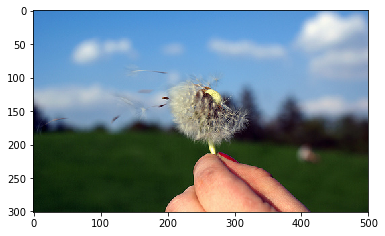

In [17]:
test_img_path = 'flower_photos/dandelion/2473862606_291ae74885.jpg'
test_img = imread(test_img_path)
plt.imshow(test_img)

In [18]:
# Run this cell if you don't have a vgg graph built
if 'vgg' in globals():
    print('"vgg" object already exists.  Will not create again.')
else:
    #create vgg
    with tf.Session() as sess:
        input_ = tf.placeholder(tf.float32, [None, 224, 224, 3])
        vgg = vgg16.Vgg16()
        vgg.build(input_)

"vgg" object already exists.  Will not create again.


In [20]:
batch = []
with tf.Session() as sess:     
    img = utils.load_image(test_img_path)
    batch.append(img.reshape((1, 224, 224, 3)))
    images = np.concatenate(batch)

    feed_dict = {input_: images}
    code = sess.run(vgg.relu6, feed_dict=feed_dict)
        
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs_: code}
    prediction = sess.run(predicted, feed_dict=feed).squeeze()

INFO:tensorflow:Restoring parameters from checkpoints/flowers.ckpt


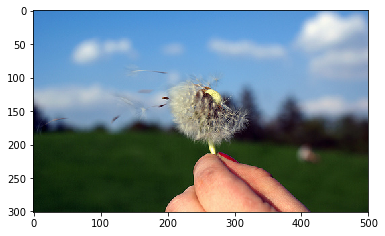

In [21]:
plt.imshow(test_img)

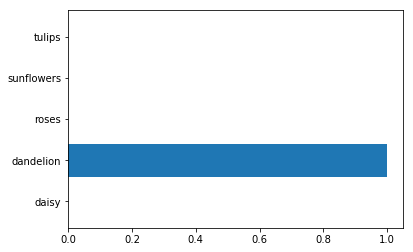

In [22]:
plt.barh(np.arange(5), prediction)
_ = plt.yticks(np.arange(5), lb.classes_)